In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import os
import matplotlib.patches as patches

In [2]:
labels = ["Coleoptera", "Diptera", "Hemiptera", "Hymenoptera", "Lepidoptera", "Odonata"]

def get_label(id): 
    return labels[id]

### Reading the tf record files

In [3]:
tf_records_path = os.path.join(os.getcwd(), "dataset/records")
tf_records = [os.path.join(tf_records_path, path) for path in os.listdir(tf_records_path)]
print(f"found {len(tf_records)} tf records files")

found 65 tf records files


In [7]:
image_feature_description = {
    "image/encoded" : tf.io.FixedLenFeature([], tf.string),
    "image/obj/heights": tf.io.VarLenFeature(tf.float32),
    "image/obj/widths": tf.io.VarLenFeature(tf.float32),
    "image/obj/lefts": tf.io.VarLenFeature(tf.float32),
    "image/obj/tops": tf.io.VarLenFeature(tf.float32),
    "image/obj/class_id": tf.io.VarLenFeature(tf.int64)
}



def parse_function(example_proto): 
    """
        deserialize a raw record
    """
    example =  tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_image(example["image/encoded"], channels=3)

    image = tf.cast(image, dtype=tf.float32) / 255.0
    
    bboxes = tf.stack([
     tf.sparse.to_dense(example["image/obj/heights"]), 
     tf.sparse.to_dense(example["image/obj/widths"]), 
     tf.sparse.to_dense(example["image/obj/lefts"]), 
     tf.sparse.to_dense(example["image/obj/tops"])
    ], axis=-1)
    # resizing all images
        
    label = tf.stack(tf.sparse.to_dense(example["image/obj/class_id"]))
    
    return image, bboxes, label
    

### functions to manipulate bounding boxes 

In [8]:
def from_hwlt_to_xyxy(bboxes): 
    """
        convert a bboxs with format whlt to xmin ymin xmax ymax format
        Input: 
            a (n,4) tensor
    """
    
    return tf.stack([
        bboxes[:,2], 
        bboxes[:,3], 
        bboxes[:,2] + bboxes[:,1],
        bboxes[:,3] + bboxes[:,0]
    ], axis=-1)

def from_xyxy_to_xywh(bboxes): 
    return tf.stack(
        [(boxes[:,0] + boxes[:, 2]) / 2,
        (boxes[:, 1] + boxes[:, 3]) / 2,
        boxes[:, 2] - boxes[:,0], 
        boxes[:, 3] - boxes[:, 1]], 
        axis=-1
    )

def from_xywh_to_xyxy(bboxes): 
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [9]:
# opening the raw dataset out of the tf records files
raw_dataset = tf.data.TFRecordDataset(tf_records)
dataset = raw_dataset.map(parse_function)

In [10]:
def parse_bboxes(image, bboxes, label): 
    print(image, bboxes, label)
    return image, from_hwlt_to_xyxy(bboxes), label

#dataset = raw_dataset.map(parse_bboxes)

### Visualizing the training data 

In [15]:
def visualize_example(image, bboxes, label):
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    
    boxes = bboxes * 448
    for bbox in boxes: 
        print(bbox)
        rect = patches.Rectangle((bbox[3], bbox[2]), bbox[1] , bbox[0], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.imshow(image) 
    plt.title(get_label(label.numpy()[0]))
    plt.show()
    

tf.Tensor([323.3754   280.96484   72.996895  70.08684 ], shape=(4,), dtype=float32)


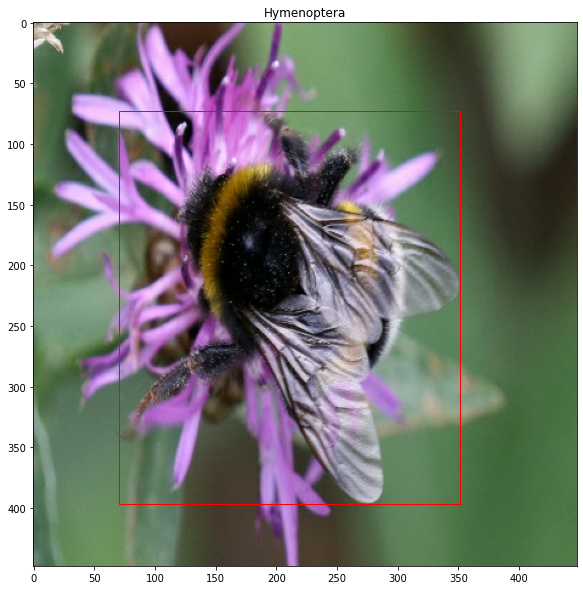

tf.Tensor([ 24.091003   9.880083 228.66183  218.59683 ], shape=(4,), dtype=float32)


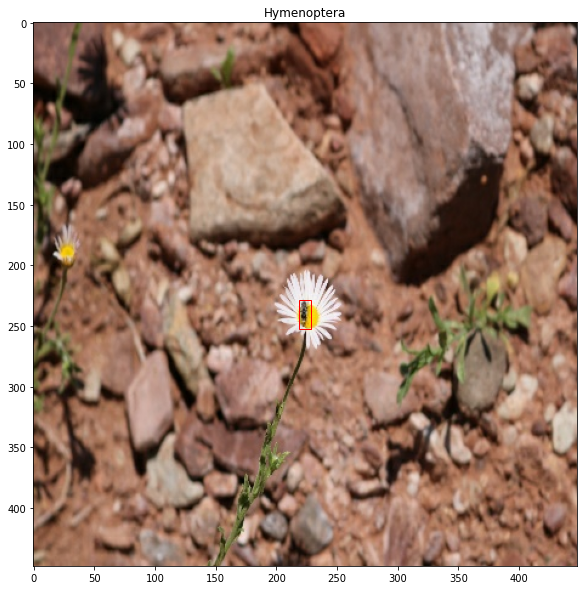

In [16]:
for image, bboxes, label in dataset.take(2): 
    visualize_example(image, bboxes, label)